<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Удалим-признаки:" data-toc-modified-id="Удалим-признаки:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Удалим признаки:</a></span></li><li><span><a href="#Масштабирование" data-toc-modified-id="Масштабирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Масштабирование</a></span></li><li><span><a href="#Двухэтапная-модель-FAISS+CatBoost" data-toc-modified-id="Двухэтапная-модель-FAISS+CatBoost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Двухэтапная модель FAISS+CatBoost</a></span><ul class="toc-item"><li><span><a href="#Создание-индексов" data-toc-modified-id="Создание-индексов-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Создание индексов</a></span></li><li><span><a href="#Отбор-кандидатов-FAISS" data-toc-modified-id="Отбор-кандидатов-FAISS-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Отбор кандидатов FAISS</a></span><ul class="toc-item"><li><span><a href="#Объединим-кандидатов-в-DataFrame" data-toc-modified-id="Объединим-кандидатов-в-DataFrame-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Объединим кандидатов в DataFrame</a></span></li><li><span><a href="#Добавим-признаки" data-toc-modified-id="Добавим-признаки-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Добавим признаки</a></span></li><li><span><a href="#read/write-df" data-toc-modified-id="read/write-df-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>read/write df</a></span></li></ul></li><li><span><a href="#Формирование-датасетов-для-обучения-катбуста" data-toc-modified-id="Формирование-датасетов-для-обучения-катбуста-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Формирование датасетов для обучения катбуста</a></span><ul class="toc-item"><li><span><a href="#Добавим-новые-признаки" data-toc-modified-id="Добавим-новые-признаки-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Добавим новые признаки</a></span></li></ul></li><li><span><a href="#Обучение-CatBoostClassifier" data-toc-modified-id="Обучение-CatBoostClassifier-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Обучение CatBoostClassifier</a></span></li><li><span><a href="#Важность-признаков" data-toc-modified-id="Важность-признаков-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Важность признаков</a></span></li><li><span><a href="#load/save_model" data-toc-modified-id="load/save_model-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>load/save_model</a></span></li><li><span><a href="#Тест-на-validation" data-toc-modified-id="Тест-на-validation-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Тест на validation</a></span><ul class="toc-item"><li><span><a href="#Отбор-кандидатов-FAISS" data-toc-modified-id="Отбор-кандидатов-FAISS-5.7.1"><span class="toc-item-num">5.7.1&nbsp;&nbsp;</span>Отбор кандидатов FAISS</a></span></li><li><span><a href="#Объединим-кандидатов-в-DataFrame" data-toc-modified-id="Объединим-кандидатов-в-DataFrame-5.7.2"><span class="toc-item-num">5.7.2&nbsp;&nbsp;</span>Объединим кандидатов в DataFrame</a></span></li><li><span><a href="#Добавим-признаки" data-toc-modified-id="Добавим-признаки-5.7.3"><span class="toc-item-num">5.7.3&nbsp;&nbsp;</span>Добавим признаки</a></span></li><li><span><a href="#Ранжирование" data-toc-modified-id="Ранжирование-5.7.4"><span class="toc-item-num">5.7.4&nbsp;&nbsp;</span>Ранжирование</a></span></li><li><span><a href="#Расчет-метрики" data-toc-modified-id="Расчет-метрики-5.7.5"><span class="toc-item-num">5.7.5&nbsp;&nbsp;</span>Расчет метрики</a></span></li></ul></li></ul></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></div>

# Matching

## Описание проекта

Есть реальные данные от одного из крупнейших маркетплейсов страны. Для каждого товара уже сформированы числовые векторы размерностью 72. Всего, наборов для обучения ~ 3 млн. 

**Цель:** разработать модель для поиска товаров, с высоким значением метрики accuracy@5 (не меньше 80%) 

**Задачи:**

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.


**Стэк:** FAISS, KNN, ранжирующие модели, индексирование в векторных базах

## Загрузка данных

In [1]:
#conda install -c conda-forge faiss

In [2]:
import pandas as pd
import numpy as np
import faiss
import phik

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
path='C:/Users/zoika/OneDrive/Рабочий стол/YP ds54/Practika/Mathing/'

In [4]:
base = pd.read_csv(path+'base.csv',index_col=0)
display(base.shape)
base.head(2)

(2918139, 72)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.42676,-118.88089,216.482440,-104.69806,-469.070588,44.348083,120.915344,181.44970,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.93361,115.26919,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.78761,-166.53348,57.680607,-86.09837,-85.076666,-35.637436,119.718636,195.23419,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.93793,116.83400,-84.888941,-59.524610


In [5]:
base=base.copy().astype(np.float16)
base.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.0625,11.156250,-64.4375,-118.875,216.5000,-104.6875,-469.0000,44.34375,120.9375,181.50,...,-42.8125,38.81250,-151.750,-74.3750,63.65625,-4.703125,92.9375,115.2500,-112.750,-60.84375
1-base,-34.5625,13.335938,-69.8125,-166.500,57.6875,-86.1250,-85.0625,-35.62500,119.6875,195.25,...,-117.7500,41.09375,-157.875,-94.4375,68.18750,24.343750,180.0000,116.8125,-84.875,-59.53125


In [6]:
train = pd.read_csv(path+'train.csv',index_col=0)
display(train.shape)
train.head(2)

(100000, 73)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.91590,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base


In [7]:
train.loc[:,'0':'71'].astype(np.float16)
train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.91590,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base


In [8]:
validation = pd.read_csv(path+'validation.csv',index_col=0)
validation=validation.astype(np.float16)
display(validation.shape)
validation.head(2)

(100000, 72)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.375,3.597656,-13.210938,-125.9375,110.7500,-81.25,-461.0,139.875,112.875,75.1875,...,-75.5000,52.84375,-143.500,59.0625,69.3125,61.9375,111.5625,115.125,-1099.0,-117.062500
100001-query,-53.750,12.789062,-43.281250,-134.3750,114.4375,-90.50,-759.5,64.000,127.125,53.1250,...,-79.4375,29.18750,-168.625,-82.8750,70.7500,-66.0000,97.0625,123.375,-744.5,-25.015625


In [9]:
validation_answer = pd.read_csv(path+'validation_answer.csv',index_col=0)
display(validation_answer.shape)
validation_answer.head(2)

(100000, 1)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base


## Масштабирование

In [11]:
features=train.copy().drop(['Target'] ,axis=1) 
targets=train["Target"].copy()

In [12]:
scaler = StandardScaler()
base[:]=scaler.fit_transform(base[:]) 
base.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.158203,0.621094,-0.51416,1.399414,2.269531,-1.160156,-0.282715,0.373535,-0.432129,0.885254,...,1.189453,0.190918,0.073914,-0.894531,-2.269531,-0.510254,0.293213,-0.014954,1.782227,-0.312744
1-base,2.076172,1.060547,-0.65332,-1.000977,-1.157227,-0.501465,1.130859,-0.871582,-0.628906,1.098633,...,-1.271484,0.270020,-0.074646,-1.096680,0.217041,0.014435,1.712891,0.058838,1.854492,-0.281250


In [13]:
features[:]=scaler.transform(features[:])
features.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,-1.459627,...,-0.866976,1.274320,-0.024409,-1.173479,-1.035366,0.197183,-0.200787,0.906574,0.995119,0.522965
1-query,-0.062145,-0.257161,0.324248,-1.543249,0.204684,-0.419327,1.095707,-1.538328,0.193790,0.246358,...,1.254598,-0.991074,0.075152,-0.159575,0.207978,0.028030,0.244772,0.709458,-0.612417,-0.083489


In [14]:
validation[:]=scaler.transform(validation[:])
validation.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,1.159180,-0.905273,0.812012,1.042969,-0.012222,-0.328369,-0.253418,1.861328,-1.701172,-0.764648,...,0.115662,0.676758,0.273926,0.453857,0.833984,0.693848,0.596680,-0.020859,-0.777832,-1.659180
100001-query,1.304688,0.950195,0.033661,0.617676,0.067322,-0.656738,-1.351562,0.679688,0.541504,-1.106445,...,-0.013618,-0.142212,-0.335449,-0.980469,1.623047,-1.618164,0.360352,0.368652,0.141846,0.545898


## Двухэтапная модель FAISS+CatBoost
Отберем кандидатов с помощью FAISS, затем ранжируем их помощью CatBoostClassifier и оставим топ-5 для расчета метрик.

**Гипотеза 1:** Двухэтапная модель FAISS+CatBoost (от 100 кандидатов на 1м этапе) даст не менее 75% точности

### Создание индексов

In [15]:
%%time 
dims = base.shape[1]   # размерность вектора признаков
n_cells =   256         # кол-во центроидов/кластеров для группировки                
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

idx_l2.train(np.ascontiguousarray(base.values[:100000, :]).astype('float16')) 
idx_l2.add(np.ascontiguousarray(base.values).astype('float16'))


CPU times: total: 18min 43s
Wall time: 1min 47s


### Отбор кандидатов FAISS 

In [16]:
%%time 
idx_l2.nprobe=32  # Проходим по топ-nprobe центроид для поиска top-k ближайших соседей
k=110 #сколько ближайших соседей искать для каждого товара
vecs, idx = idx_l2.search(np.ascontiguousarray(features.values).astype('float32'), k)  

CPU times: total: 1h 9min 8s
Wall time: 6min 1s


In [17]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [18]:
acc = 0
for target, el in tqdm(zip(targets.values.tolist(), idx.tolist())):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

100000it [00:03, 25955.64it/s]


78.076


#### Объединим кандидатов в DataFrame

In [19]:
def con_candidate(i,l,lnew,validation):
    for j in range(len(l)):
        lnew.append([i, validation.index[i],base_index[l[j]] ,j ])
    return lnew

In [20]:
lnew=[]
for i in tqdm(range(len(idx))):    
    lnew=con_candidate(i,idx[i],lnew,train)

df_t_new=pd.DataFrame(data=lnew,columns=['id_num','id_name','id_cand_name','rank'])
display(df_t_new.shape)
df_t_new.head(4)

100%|██████████| 100000/100000 [00:12<00:00, 8043.00it/s]


(11000000, 4)

,id_num,id_name,id_cand_name,rank
0,0,0-query,675816-base,0
1,0,0-query,877519-base,1
2,0,0-query,361564-base,2
3,0,0-query,2725256-base,3


In [23]:
del lnew

#### Добавим признаки

Добавим целевой признак.
Заполним колонку **"ground truth"**, где будет 1 - если товар-кандидат совпал с товаром, отмеченным экспертом, и 0 - в противном случае
Эта колонка будет целевой признак при обучении второй модели


In [24]:
%%time
#присоединим 'Target':  
df=pd.merge(df_t_new, train[['Target']], how='left', left_on='id_name', right_on=train.index).copy() 

df['ground truth']=(df["id_cand_name"]==df["Target"])
df['ground truth'].apply(lambda x: int(x))   #df['ground truth']=
df=df.drop(['Target'],axis=1)
df.head(2)

CPU times: total: 8.44 s
Wall time: 8.44 s


,id_num,id_name,id_cand_name,rank,ground truth
0,0,0-query,675816-base,0,True
1,0,0-query,877519-base,1,False


 Добавим признаки товарам

In [25]:
#присоединим хар-ки основного товара:
df=pd.merge(df, features, how='left', left_on='id_name', right_on=features.index)  

#присоединим хар-ки кандидатов
df=pd.merge(df, base.add_suffix('_cand'), how='left', left_on='id_cand_name', right_on=base.index)
df.head(2)

,id_num,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,...,62_cand,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand
0,0,0-query,675816-base,0,True,1.299521,1.996883,0.063773,-1.879674,1.644099,...,-0.927246,1.626953,0.073914,0.427246,-0.502441,0.395020,-0.568359,0.067688,0.995605,0.708984
1,0,0-query,877519-base,1,False,1.299521,1.996883,0.063773,-1.879674,1.644099,...,-0.676758,1.614258,-0.247437,-0.404297,-1.153320,0.412598,-0.375732,0.728516,0.543945,0.270508


#### read/write df


In [ ]:
#%%time
#df.to_csv("cand_100_78.csv", index=False)   #!!!!!!Wall time: 33min 23s
#df=pd.read_csv("candidati_all_100_NEW2.csv")  #Wall time: 6min 32s
#display(df.shape)
#df.head(2)

### Формирование датасетов для обучения катбуста

#### Добавим новые признаки
Как модули между некоторыми, существующими признаками

In [26]:
df['abs70']=abs(df['70']-df['70_cand'])
df['abs33']=abs(df['33']-df['33_cand'])
df['abs6']=abs(df['6']-df['6_cand'])
df['abs44']=abs(df['44']-df['44_cand'])
df['abs21']=abs(df['21']-df['21_cand'])

In [ ]:
#test_size=0.25

In [27]:
df_mini=df.loc[:,'id_name':].copy()

display(df_mini.shape)
df_mini.head(1)

(11000000, 153)

,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,5,...,67_cand,68_cand,69_cand,70_cand,71_cand,abs70,abs33,abs6,abs44,abs21
0,0-query,675816-base,0,True,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,...,0.39502,-0.568359,0.067688,0.995605,0.708984,0.000486,0.567362,0.000439,0.180287,1.521696


In [28]:
feat_col=df_mini.columns.to_list()  #список колонок с признаками, для катбуста
feat_col=feat_col[2:]
feat_col.remove('ground truth')
len(feat_col)

150

In [29]:
#feat_col.remove('Target')

In [30]:
features_train_m=df_mini[:9000000].copy()
features_test_m=df_mini[9000000:10000000].copy()
print(features_train_m.shape, ';', features_test_m.shape)

(9000000, 153) ; (1000000, 153)


In [31]:
features_train_m[feat_col].head(4)

,rank,0,1,2,3,4,5,6,7,8,...,67_cand,68_cand,69_cand,70_cand,71_cand,abs70,abs33,abs6,abs44,abs21
0,0,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,...,0.395020,-0.568359,0.067688,0.995605,0.708984,0.000486,0.567362,0.000439,0.180287,1.521696
1,1,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,...,0.412598,-0.375732,0.728516,0.543945,0.270508,0.451174,0.000509,0.837940,0.000377,0.915804
2,2,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,...,0.281006,-0.491943,0.530762,0.542969,0.090088,0.452150,0.424337,1.516651,0.180287,1.521696
3,3,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,...,0.156128,-1.269531,0.008652,1.964844,0.834473,0.969725,0.163065,0.057605,0.180287,0.226351


### Обучение CatBoostClassifier 

Используем CatBoostClassifier для ранжирования кандидатов.В качестве ранга возьмем вероятность принадлежности к классу 1, запишем ее в колонку "cb_proba".

Так как, выборка получилась сильно несбалансированная, при обучении используем аргумент class_weights. Соотношение возьмем пропорционально числу кандидатов, так как верный - максимум один из всех

In [32]:
target_mini=df_mini[['ground truth']].copy()
target_train_m=target_mini[:9000000].copy()
target_test_m=target_mini[9000000:10000000].copy()
print(target_train_m.shape, ';', features_test_m.shape)

(9000000, 1) ; (1000000, 153)


In [33]:
#k=100

### Важность признаков

In [34]:
%%time

model = CatBoostClassifier(iterations=800,learning_rate=0.1, class_weights=(1, k-1))  #k - ckolko candidatov learning_rate=0.1,

model.fit(features_train_m[feat_col],
          target_train_m,
          eval_set=(features_test_m[feat_col],target_test_m),
          early_stopping_rounds=25,
          plot=True,
          verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4970207	test: 0.4972502	best: 0.4972502 (0)	total: 2.1s	remaining: 27m 56s
100:	learn: 0.0643815	test: 0.0669108	best: 0.0669108 (100)	total: 2m 43s	remaining: 18m 50s
200:	learn: 0.0569817	test: 0.0618578	best: 0.0618578 (200)	total: 5m 23s	remaining: 16m 4s
300:	learn: 0.0520860	test: 0.0593830	best: 0.0593830 (300)	total: 7m 54s	remaining: 13m 6s
400:	learn: 0.0481575	test: 0.0577574	best: 0.0577547 (399)	total: 10m 25s	remaining: 10m 22s
500:	learn: 0.0450326	test: 0.0571202	best: 0.0571121 (499)	total: 12m 52s	remaining: 7m 40s
600:	learn: 0.0422649	test: 0.0566318	best: 0.0566018 (595)	total: 15m 19s	remaining: 5m 4s
700:	learn: 0.0398292	test: 0.0561317	best: 0.0561317 (700)	total: 17m 43s	remaining: 2m 30s
799:	learn: 0.0375052	test: 0.0557849	best: 0.0557758 (777)	total: 20m 10s	remaining: 0us

bestTest = 0.05577576173
bestIteration = 777

Shrink model to first 778 iterations.
CPU times: total: 3h 45min 29s
Wall time: 23min 43s


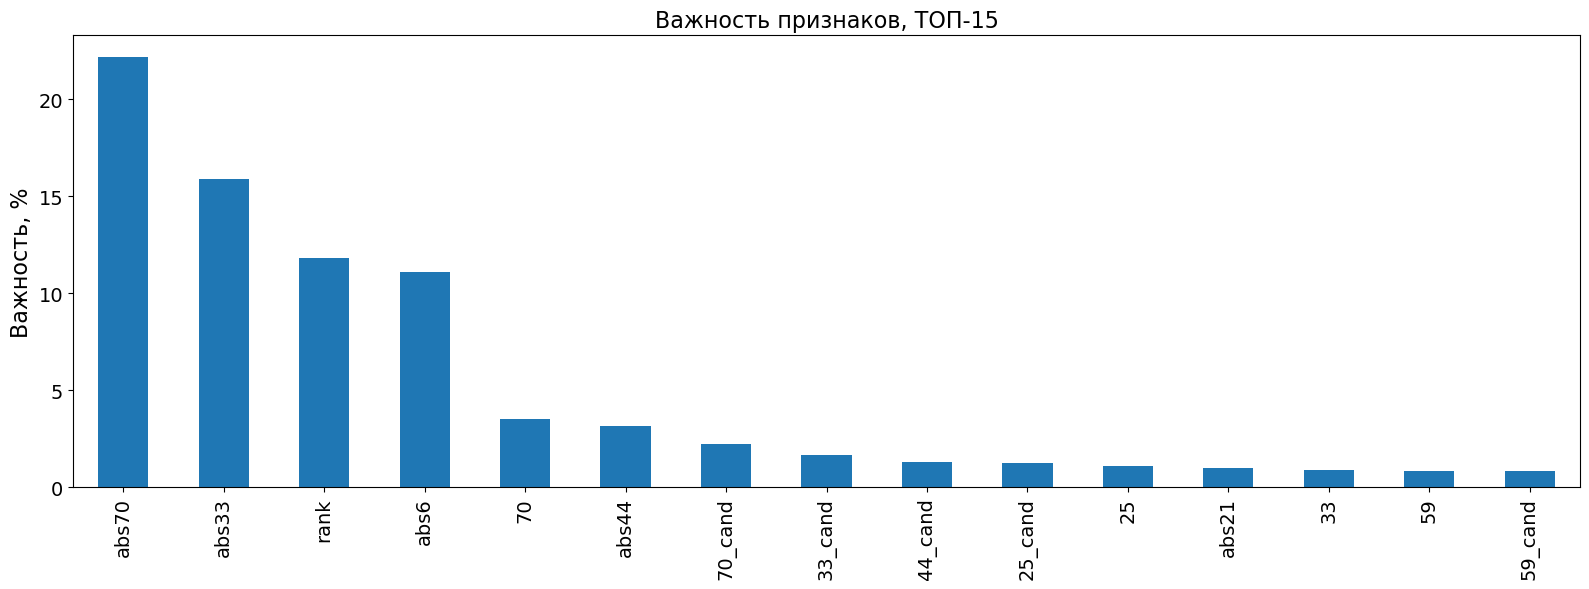

In [35]:
fi = pd.Series(model.get_feature_importance(),feat_col)          
fig, ax = plt.subplots(figsize=(16,6))
fi.sort_values(ascending=False).head(15).plot.bar(ax=ax,fontsize=14)
ax.set_title("Важность признаков, ТОП-15", fontsize=16)
ax.set_ylabel('Важность, %', fontsize=16)
fig.tight_layout( )

### Тест на validation

In [36]:
expected=validation_answer['Expected'].copy()

In [37]:
validation.shape

(100000, 72)

In [38]:
validation_answer.head(2)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base


#### Отбор кандидатов FAISS 

In [39]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(validation.values).astype('float32'), k)  

CPU times: total: 1h 8min 46s
Wall time: 6min 3s


#### Объединим кандидатов в DataFrame

In [40]:
lnew=[]
for i in tqdm(range(len(idx))):   
    lnew=con_candidate(i,idx[i],lnew,validation)

df_t_new=pd.DataFrame(data=lnew,columns=['id_num','id_name','id_cand_name','rank'])
display(df_t_new.shape)
df_t_new.head(2)

100%|██████████| 100000/100000 [00:14<00:00, 6809.51it/s]


(11000000, 4)

,id_num,id_name,id_cand_name,rank
0,0,100000-query,3209652-base,0
1,0,100000-query,3181043-base,1


In [41]:
del lnew

#### Добавим признаки

In [42]:
%%time 
#присоединим 'Target':  
del df
df=pd.merge(df_t_new, validation_answer[['Expected']], how='left', left_on='id_name', right_on=validation_answer.index).copy() 

CPU times: total: 3.12 s
Wall time: 3.16 s


In [43]:
%%time
df['ground truth']=(df["id_cand_name"]==df["Expected"])
df['ground truth']=df['ground truth'].apply(lambda x: int(x))
df=df.drop(['Expected'],axis=1)
df.head(2)

CPU times: total: 5.25 s
Wall time: 5.26 s


,id_num,id_name,id_cand_name,rank,ground truth
0,0,100000-query,3209652-base,0,0
1,0,100000-query,3181043-base,1,0


In [44]:
#присоединим хар-ки основного товара:
df=pd.merge(df, validation, how='left', left_on='id_name', right_on=validation.index).copy()   

#присоединим хар-ки кандидатов
df=pd.merge(df, base.add_suffix('_cand'), how='left', left_on='id_cand_name', right_on=base.index).copy() 
df.head(2)

,id_num,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,...,62_cand,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand
0,0,100000-query,3209652-base,0,0,1.15918,-0.905273,0.812012,1.042969,-0.012222,...,0.458496,0.949219,0.571289,1.213867,0.902344,0.898438,0.019012,0.430664,-0.712891,-1.183594
1,0,100000-query,3181043-base,1,0,1.15918,-0.905273,0.812012,1.042969,-0.012222,...,0.191650,0.477539,-0.017059,0.169922,0.559570,0.766113,0.048553,0.406982,-0.712891,-1.284180


In [45]:
df['abs70']=abs(df['70']-df['70_cand'])
df['abs33']=abs(df['33']-df['33_cand'])
df['abs6']=abs(df['6']-df['6_cand'])
df['abs44']=abs(df['44']-df['44_cand'])
df['abs21']=abs(df['21']-df['21_cand'])

#### Ранжирование

In [47]:
g=features_test_m[feat_col]

In [48]:
features_test_m=df.copy()
features_test_m["cb_proba"] = model.predict_proba(features_test_m[feat_col])[:,1]
features_test_m.head(1)

,id_num,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,...,68_cand,69_cand,70_cand,71_cand,abs70,abs33,abs6,abs44,abs21,cb_proba
0,0,100000-query,3209652-base,0,0,1.15918,-0.905273,0.812012,1.042969,-0.012222,...,0.019012,0.430664,-0.712891,-1.183594,0.064941,0.318848,1.082031,0.0,0.189453,0.761021


In [49]:
features_test_m.head(1)

,id_num,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,...,68_cand,69_cand,70_cand,71_cand,abs70,abs33,abs6,abs44,abs21,cb_proba
0,0,100000-query,3209652-base,0,0,1.15918,-0.905273,0.812012,1.042969,-0.012222,...,0.019012,0.430664,-0.712891,-1.183594,0.064941,0.318848,1.082031,0.0,0.189453,0.761021


In [51]:
features_test_m["cb_proba"] = model.predict_proba(features_test_m[feat_col])[:,1]

In [52]:
#оставим только важные столбцы
dff=features_test_m[['id_name','id_cand_name','rank','cb_proba','ground truth']]
dff.head(2)

,id_name,id_cand_name,rank,cb_proba,ground truth
0,100000-query,3209652-base,0,0.761021,0
1,100000-query,3181043-base,1,0.192681,0


In [53]:
dff_table=dff.sort_values(['id_name','cb_proba'],ascending=False).groupby('id_name').head(5) # отсортируем по убыванию  
display(dff_table.shape)
dff_table.head(6)

(500000, 5)

,id_name,id_cand_name,rank,cb_proba,ground truth
10999909,199999-query,336472-base,19,0.942775,1
10999890,199999-query,4678196-base,0,0.697740,0
10999891,199999-query,3842322-base,1,0.212717,0
10999895,199999-query,2503531-base,5,0.076624,0
10999915,199999-query,2818124-base,25,0.044530,0
10999780,199998-query,341779-base,0,0.999772,1


#### Расчет метрики

Для расчета метрики, отсортируем кандидатов по вероятности и возьмем топ-5. Затем, можно просто проссумировать единички с колонки "ground truth" и поделить на количество товаров

In [54]:
acc5=(dff_table['ground truth'].sum())/ (len(dff_table)/5) *100 # среднее число единиц на каждую пятерку строк, в % 
acc5

75.234

## Выводы:

Разработали двух-этапную модель. На первом этапе отобрали 100 кандидатов. Из которых, с пмощью катбуста выбрали 5. Добились хорошей метрики
